### Dataset Link

https://drive.google.com/drive/folders/1VoZdg-ro-FqNYcoQ_SEcOYYpsOI9STFP


### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os

### Data Gathering

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Data Preprocessing

In [3]:
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Step 1: Read Labels CSV Files
def read_labels_csv(folder):
    labels_df = pd.read_csv(os.path.join(folder, '_classes.csv'))
    return labels_df

train_labels = read_labels_csv('/content/drive/MyDrive/Vehicle Detection Project/train')
valid_labels = read_labels_csv('/content/drive/MyDrive/Vehicle Detection Project/valid')
test_labels = read_labels_csv('/content/drive/MyDrive/Vehicle Detection Project/test')


def decode_one_hot_encoding(labels_df):
    # one-hot encoding columns are ['Ambulance', 'Bus', 'Car', 'Motorcycle', 'Truck']
    one_hot_columns = [' Ambulance', ' Bus', ' Car', ' Motorcycle', ' Truck']
    labels_df['vehicle_name'] = labels_df[one_hot_columns].idxmax(axis=1)
    return labels_df

train_labels = decode_one_hot_encoding(train_labels)
valid_labels = decode_one_hot_encoding(valid_labels)
test_labels = decode_one_hot_encoding(test_labels)

def create_vehicle_folders(labels_df, folder):
    vehicles = ['Ambulance', 'Bus', 'Car', 'Motorcycle', 'Truck']
    for vehicle in vehicles:
        os.makedirs(os.path.join(folder, vehicle), exist_ok=True)

create_vehicle_folders(train_labels, 'train')
create_vehicle_folders(valid_labels, 'valid')
create_vehicle_folders(test_labels, 'test')

In [4]:
def move_images_to_vehicle_folders(labels_df, folder, dest_folder):
    for index, row in labels_df.iterrows():
        source_path = os.path.join(folder, row['filename'])
        destination_folder = os.path.join(dest_folder, row['vehicle_name'].strip())
        destination_path = os.path.join(destination_folder, os.path.basename(row['filename']))

        try:
            with open(source_path, 'rb') as src_file:
                with open(destination_path, 'wb') as dest_file:
                    shutil.copyfileobj(src_file, dest_file)
        except FileNotFoundError:
            print(f"Source image {source_path} not found!")
        except Exception as e:
            print(f"An error occurred while copying image {source_path}: {e}")

move_images_to_vehicle_folders(train_labels, '/content/drive/MyDrive/Vehicle Detection Project/train', 'train')
move_images_to_vehicle_folders(valid_labels, '/content/drive/MyDrive/Vehicle Detection Project/valid', 'valid')
move_images_to_vehicle_folders(test_labels, '/content/drive/MyDrive/Vehicle Detection Project/test', 'test')

In [5]:
train_labels

,filename,Ambulance,Bus,Car,Motorcycle,Truck,vehicle_name
0,7845ed5a26cb9fd4_jpg.rf.4774c33772ba8a86565de0...,0,0,1,0,0,Car
1,da386cf96761ef58_jpg.rf.3fe7704d2d3bb730cf1d6f...,1,0,0,0,0,Ambulance
2,d8457fa9476ca19f_jpg.rf.3ed8724e9eb05417ffc9a0...,0,0,0,1,0,Motorcycle
3,abbe2d8b6072322a_jpg.rf.48dfa7eadaba905cf0cf2d...,0,0,1,0,0,Car
4,cc266fd9ac857379_jpg.rf.450c264f0add70543b221a...,0,0,1,0,0,Car
...,...,...,...,...,...,...,...
873,547c1b1416d7b64d_jpg.rf.bc4e7a779ac5ccc58c74ce...,1,0,0,0,0,Ambulance
874,b856e2f0ec2e5fcc_jpg.rf.c4d72233e8631ace37177e...,0,1,0,0,0,Bus
875,552a0d9a0fc92dac_jpg.rf.c1d215d149e6deb7126925...,0,0,1,0,0,Car
876,44e913fc3c81999f_jpg.rf.c4ca9965aa32ea5d6c4ec7...,0,0,1,0,0,Car


In [6]:
print(os.listdir('train'))
print(os.listdir('valid'))
print(os.listdir('test'))

['Car', 'Bus', 'Motorcycle', 'Truck', 'Ambulance']
['Car', 'Bus', 'Motorcycle', 'Truck', 'Ambulance']
['Car', 'Bus', 'Motorcycle', 'Truck', 'Ambulance']


In [7]:
num_classes = len(os.listdir('train'))
num_classes

5

### Data Visualization

<Axes: xlabel='vehicle_name'>

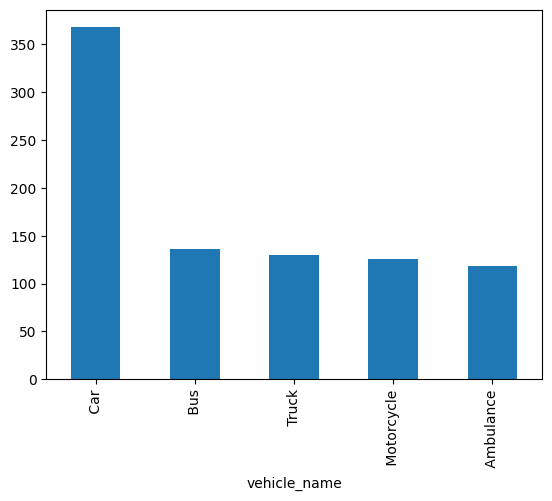

In [8]:
train_labels['vehicle_name'].value_counts().plot(kind='bar')

<Axes: xlabel='vehicle_name'>

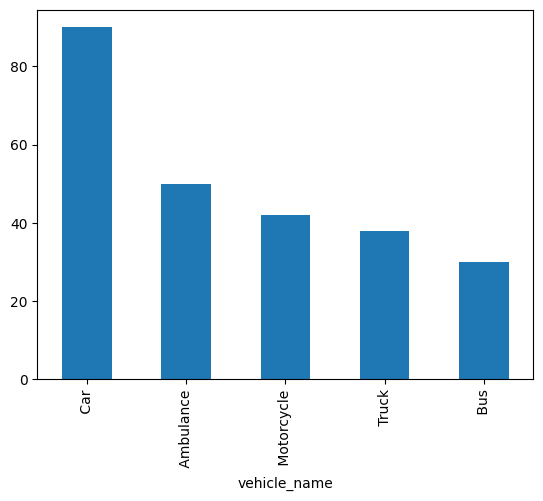

In [9]:
valid_labels['vehicle_name'].value_counts().plot(kind='bar')

<Axes: xlabel='vehicle_name'>

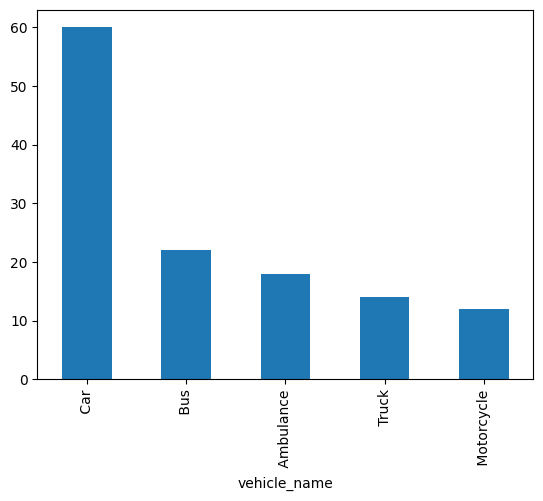

In [10]:
test_labels['vehicle_name'].value_counts().plot(kind='bar')

By Viualizing this, we can conclude that our dataset is highly imbalanced towards 'Car' Class.

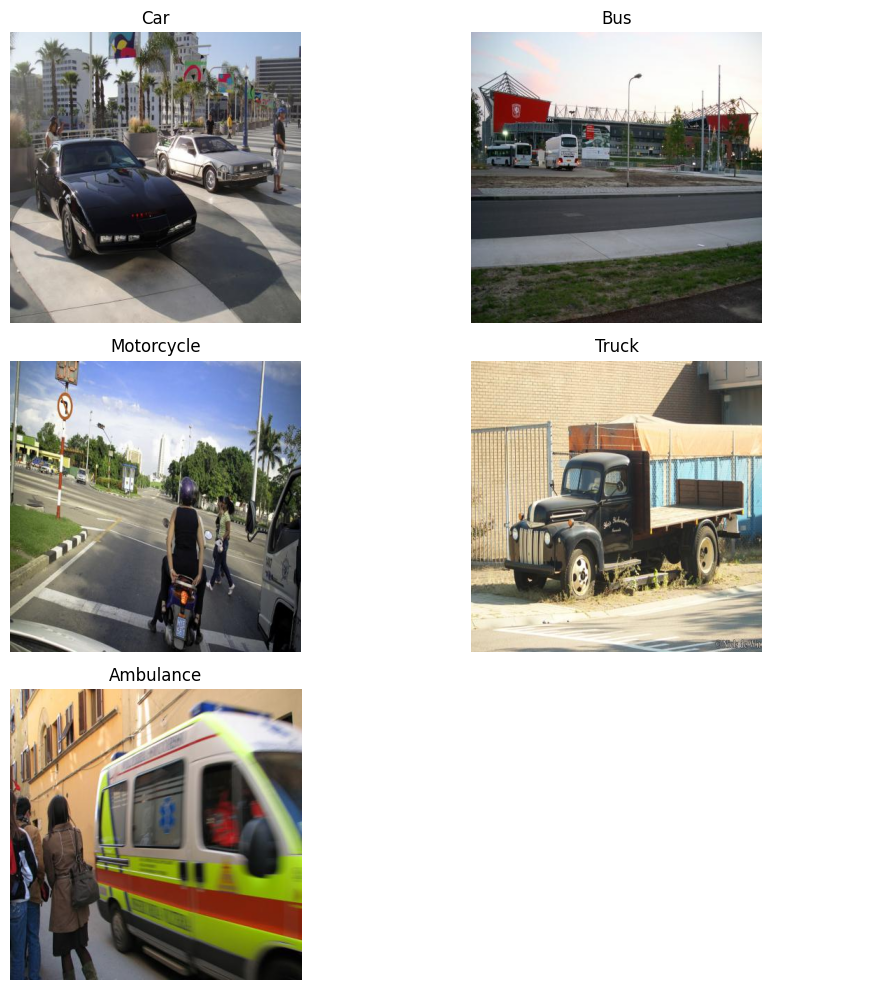

In [11]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

train_folder = 'train'
classes = os.listdir(train_folder)

num_classes = len(classes)
num_rows = (num_classes + 1) // 2
num_cols = 2

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))

for i, class_name in enumerate(classes):
    images = os.listdir(os.path.join(train_folder, class_name))
    image_path = os.path.join(train_folder, class_name, images[0])
    img = mpimg.imread(image_path)
    axes[i // num_cols, i % num_cols].imshow(img)
    axes[i // num_cols, i % num_cols].set_title(class_name)
    axes[i // num_cols, i % num_cols].axis('off')

# Hide any empty subplots
for j in range(num_classes, num_rows * num_cols):
    axes[j // num_cols, j % num_cols].axis('off')

plt.tight_layout()
plt.show()

### Model Training

In [12]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# Define train and validation directories
train_dir = 'train'
valid_dir = 'valid'
test_dir = 'test'

# Define image dimensions and batch size
img_height, img_width = 416,416
batch_size = 32

# Create ImageDataGenerator with augmentation for minority classes
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# No augmentation for validation data
valid_datagen = ImageDataGenerator(rescale=1./255)

# Create ImageDataGenerator for test data (no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Flow validation images in batches using valid_datagen generator
valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Flow test images in batches using test_datagen generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 878 images belonging to 5 classes.
Found 250 images belonging to 5 classes.
Found 126 images belonging to 5 classes.


In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2

def create_mobilenet_model(input_shape, num_classes):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(256, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)

    return model

# Create the MobileNetV2 model
model = create_mobilenet_model(input_shape=(416, 416, 3), num_classes=5)

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display model summary
model.summary()

9406464/9406464 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 416, 416, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 208, 208, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 208, 208, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (N

In [14]:
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=valid_generator
)

Epoch 1/20
28/28 [==============================] - 49s 1s/step - loss: 1.0196 - accuracy: 0.6105 - val_loss: 0.7468 - val_accuracy: 0.7760
Epoch 2/20
28/28 [==============================] - 39s 1s/step - loss: 0.5658 - accuracy: 0.8007 - val_loss: 0.6109 - val_accuracy: 0.8080
Epoch 3/20
28/28 [==============================] - 39s 1s/step - loss: 0.4671 - accuracy: 0.8235 - val_loss: 0.5533 - val_accuracy: 0.8240
Epoch 4/20
28/28 [==============================] - 40s 1s/step - loss: 0.3562 - accuracy: 0.8793 - val_loss: 0.5882 - val_accuracy: 0.7840
Epoch 5/20
28/28 [==============================] - 40s 1s/step - loss: 0.3045 - accuracy: 0.8918 - val_loss: 0.5521 - val_accuracy: 0.8240
Epoch 6/20
28/28 [==============================] - 39s 1s/step - loss: 0.2521 - accuracy: 0.9237 - val_loss: 0.6028 - val_accuracy: 0.8080
Epoch 7/20
28/28 [==============================] - 39s 1s/step - loss: 0.2164 - accuracy: 0.9351 - val_loss: 0.5923 - val_accuracy: 0.8160
Epoch 8/20
28/28 [==

### Evaluating the Model

In [15]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

4/4 [==============================] - 3s 897ms/step - loss: 0.5842 - accuracy: 0.8095
Test loss: 0.5842128396034241
Test accuracy: 0.8095238208770752


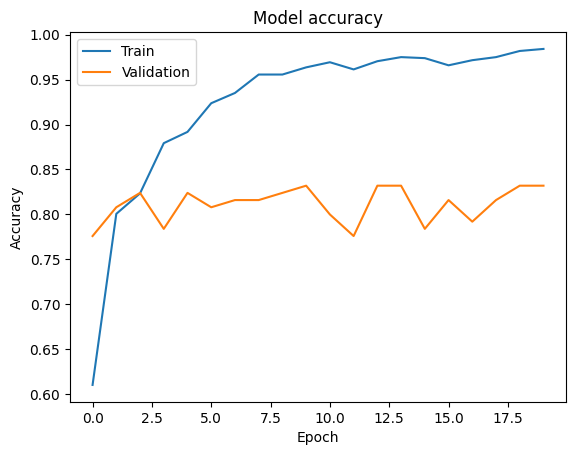

In [16]:
# Plot training & validation accuracy values
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

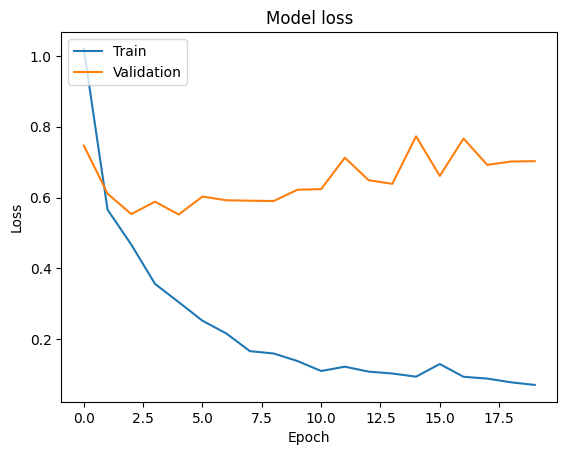

In [17]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Saving the Model

In [19]:
model.export('Vehicle Classification Model.h5')

Saved artifact at 'Vehicle Classification Model.h5'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 416, 416, 3), dtype=tf.float32, name='input_1')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  133589518461664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133589517612512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133589517605648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133589517609696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133589518462192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133589516697120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133589517599312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133589482922480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133589482923888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133589516696064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1335

In [21]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
!cp -r /content/Vehicle\ Classification\ Model /content/drive/MyDrive/

Mounted at /content/drive
